In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re,string,unicodedata
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import datetime
%matplotlib inline

In [2]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

### Preparing fake-news dataset

In [3]:
fake1 = pd.read_csv("../input/fake-news/fake.csv")
# removing all unnecessary columns
fake1 = fake1[['title', 'text', 'language']]
# removing non-english articles
fake1 = fake1[fake1['language'] == 'english']
del fake1['language']
fake1['category'] = 0
# drop rows with missing values
fake1 = fake1.dropna(axis=0)

fake1.head()

,title,text,category
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,0
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,0
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,0


### Preparing real-and-fake-news-dataset

In [4]:
real_fake = pd.read_csv("../input/real-and-fake-news-dataset/news.csv")
# removing all unnecessary columns
del real_fake['Unnamed: 0']

# turning label into boolean category (1 for real, 0 for fake)
d = {'REAL': 1, 'FAKE': 0}
real_fake['category'] = real_fake['label'].map(d)
del real_fake['label']
# drop rows with missing values
real_fake = real_fake.dropna(axis=0)

real_fake.head()

,title,text,category
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


### Preparing source-based-news-classification

In [5]:
# source_based = pd.read_csv("../input/source-based-news-classification/news_articles.csv")
# # removing non-english articles
# source_based = source_based[source_based['language'] == 'english']
# # removing all unnecessary columns
# source_based = source_based[['title', 'text', 'label']]

# # turning labels intoo boolean category (1 for real, 0 for fake)
# dic = {'Real': 1, 'Fake': 0}
# source_based['category'] = source_based['label'].map(dic)
# del source_based['label']

# source_based.head()

In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
news = pd.concat([true,false])

<AxesSubplot:xlabel='category', ylabel='count'>

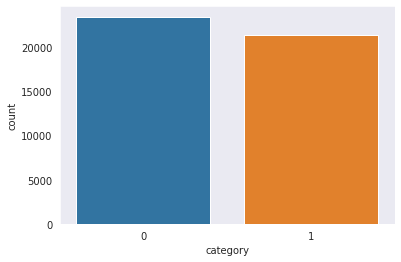

In [10]:
sns.set_style("dark")
# Count occurences of both real and fake news
sns.countplot(x=news.category)

In [11]:
news['text'] = news['text'] + " " + news['title']
fake1['text'] = fake1['text'] + " " + fake1['title']
real_fake['text'] = real_fake['text'] + " " + real_fake['title']
del news['title']
del fake1['title']
del real_fake['title']
del news['subject']
del news['date']

In [12]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
fake1['text']

0        Print They should pay all the back all the mon...
1        Why Did Attorney General Loretta Lynch Plead T...
2        Red State : \nFox News Sunday reported this mo...
3        Email Kayla Mueller was a prisoner and torture...
4        Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...
                               ...                        
12908    Oct 26, 2016 4:26 PM 0 SHARES \nThere was a su...
12909    The following video is a must watch, particula...
12910    She explains : \nHillary Clinton wants to star...
12911    YHC-FTSE Oct 26, 2016 5:14 PM \nWould have bee...
12912    Oct 26, 2016 5:20 PM 0 \nSubmitted by Joseph J...
Name: text, Length: 11677, dtype: object

### Data Cleaning

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['text']=news['text'].apply(denoise_text)
fake1['text'] = fake1['text'].apply(denoise_text)
real_fake['text'] = real_fake['text'].apply(denoise_text)

In [14]:
# Concatenate all datasets into one
all_news = pd.concat([news,fake1, real_fake])

In [15]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(all_news.text)

In [16]:
x_train,x_test,y_train,y_test = train_test_split(all_news.text,all_news.category,random_state = 27)

### Training

In [17]:
max_features = 10000
maxlen = 300

In [18]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [19]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [20]:
# Model Hyperparameters
batch_size = 256
epochs = 5
embed_size = 100

In [21]:
model = Sequential([
                    Embedding(max_features, embed_size, input_length=maxlen),
                    Bidirectional(LSTM(150, return_sequences=True, dropout=0.25)),
                    LSTM(100, dropout=0.1),
                    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

2022-03-04 16:10:49.828732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 16:10:49.931918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 16:10:49.932634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 16:10:49.933792: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_test,y_test)
)

2022-03-04 16:10:52.886125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-03-04 16:10:57.589196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


185/185 [==============================] - 31s 138ms/step - loss: 0.3758 - acc: 0.9209 - val_loss: 0.1392 - val_acc: 0.9663
Epoch 2/5
185/185 [==============================] - 25s 133ms/step - loss: 0.0810 - acc: 0.9792 - val_loss: 0.1001 - val_acc: 0.9701
Epoch 3/5
185/185 [==============================] - 25s 133ms/step - loss: 0.0496 - acc: 0.9871 - val_loss: 0.1038 - val_acc: 0.9691
Epoch 4/5
185/185 [==============================] - 25s 133ms/step - loss: 0.0349 - acc: 0.9920 - val_loss: 0.1051 - val_acc: 0.9729
Epoch 5/5
185/185 [==============================] - 25s 133ms/step - loss: 0.0237 - acc: 0.9949 - val_loss: 0.1036 - val_acc: 0.9744


### Evaluation

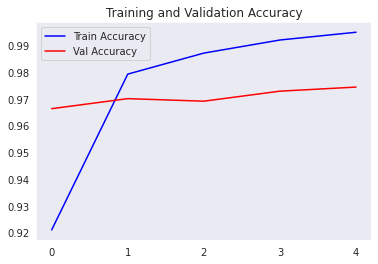

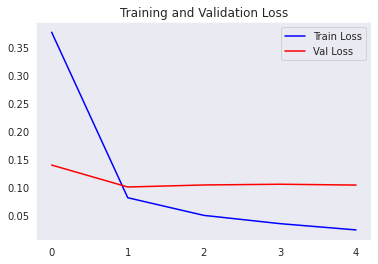

In [23]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(acc, color='b', label='Train Accuracy')
plt.plot(val_acc, color='r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks([i for i in range(epochs)])
plt.legend()

plt.figure()
plt.plot(loss, color='b', label='Train Loss')
plt.plot(val_loss, color='r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xticks([i for i in range(epochs)])
plt.legend()

#accuracy, precision, recall f1_score